In [2]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [3]:
df=pd.read_csv('diabetes.csv')
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


## Исследование данных

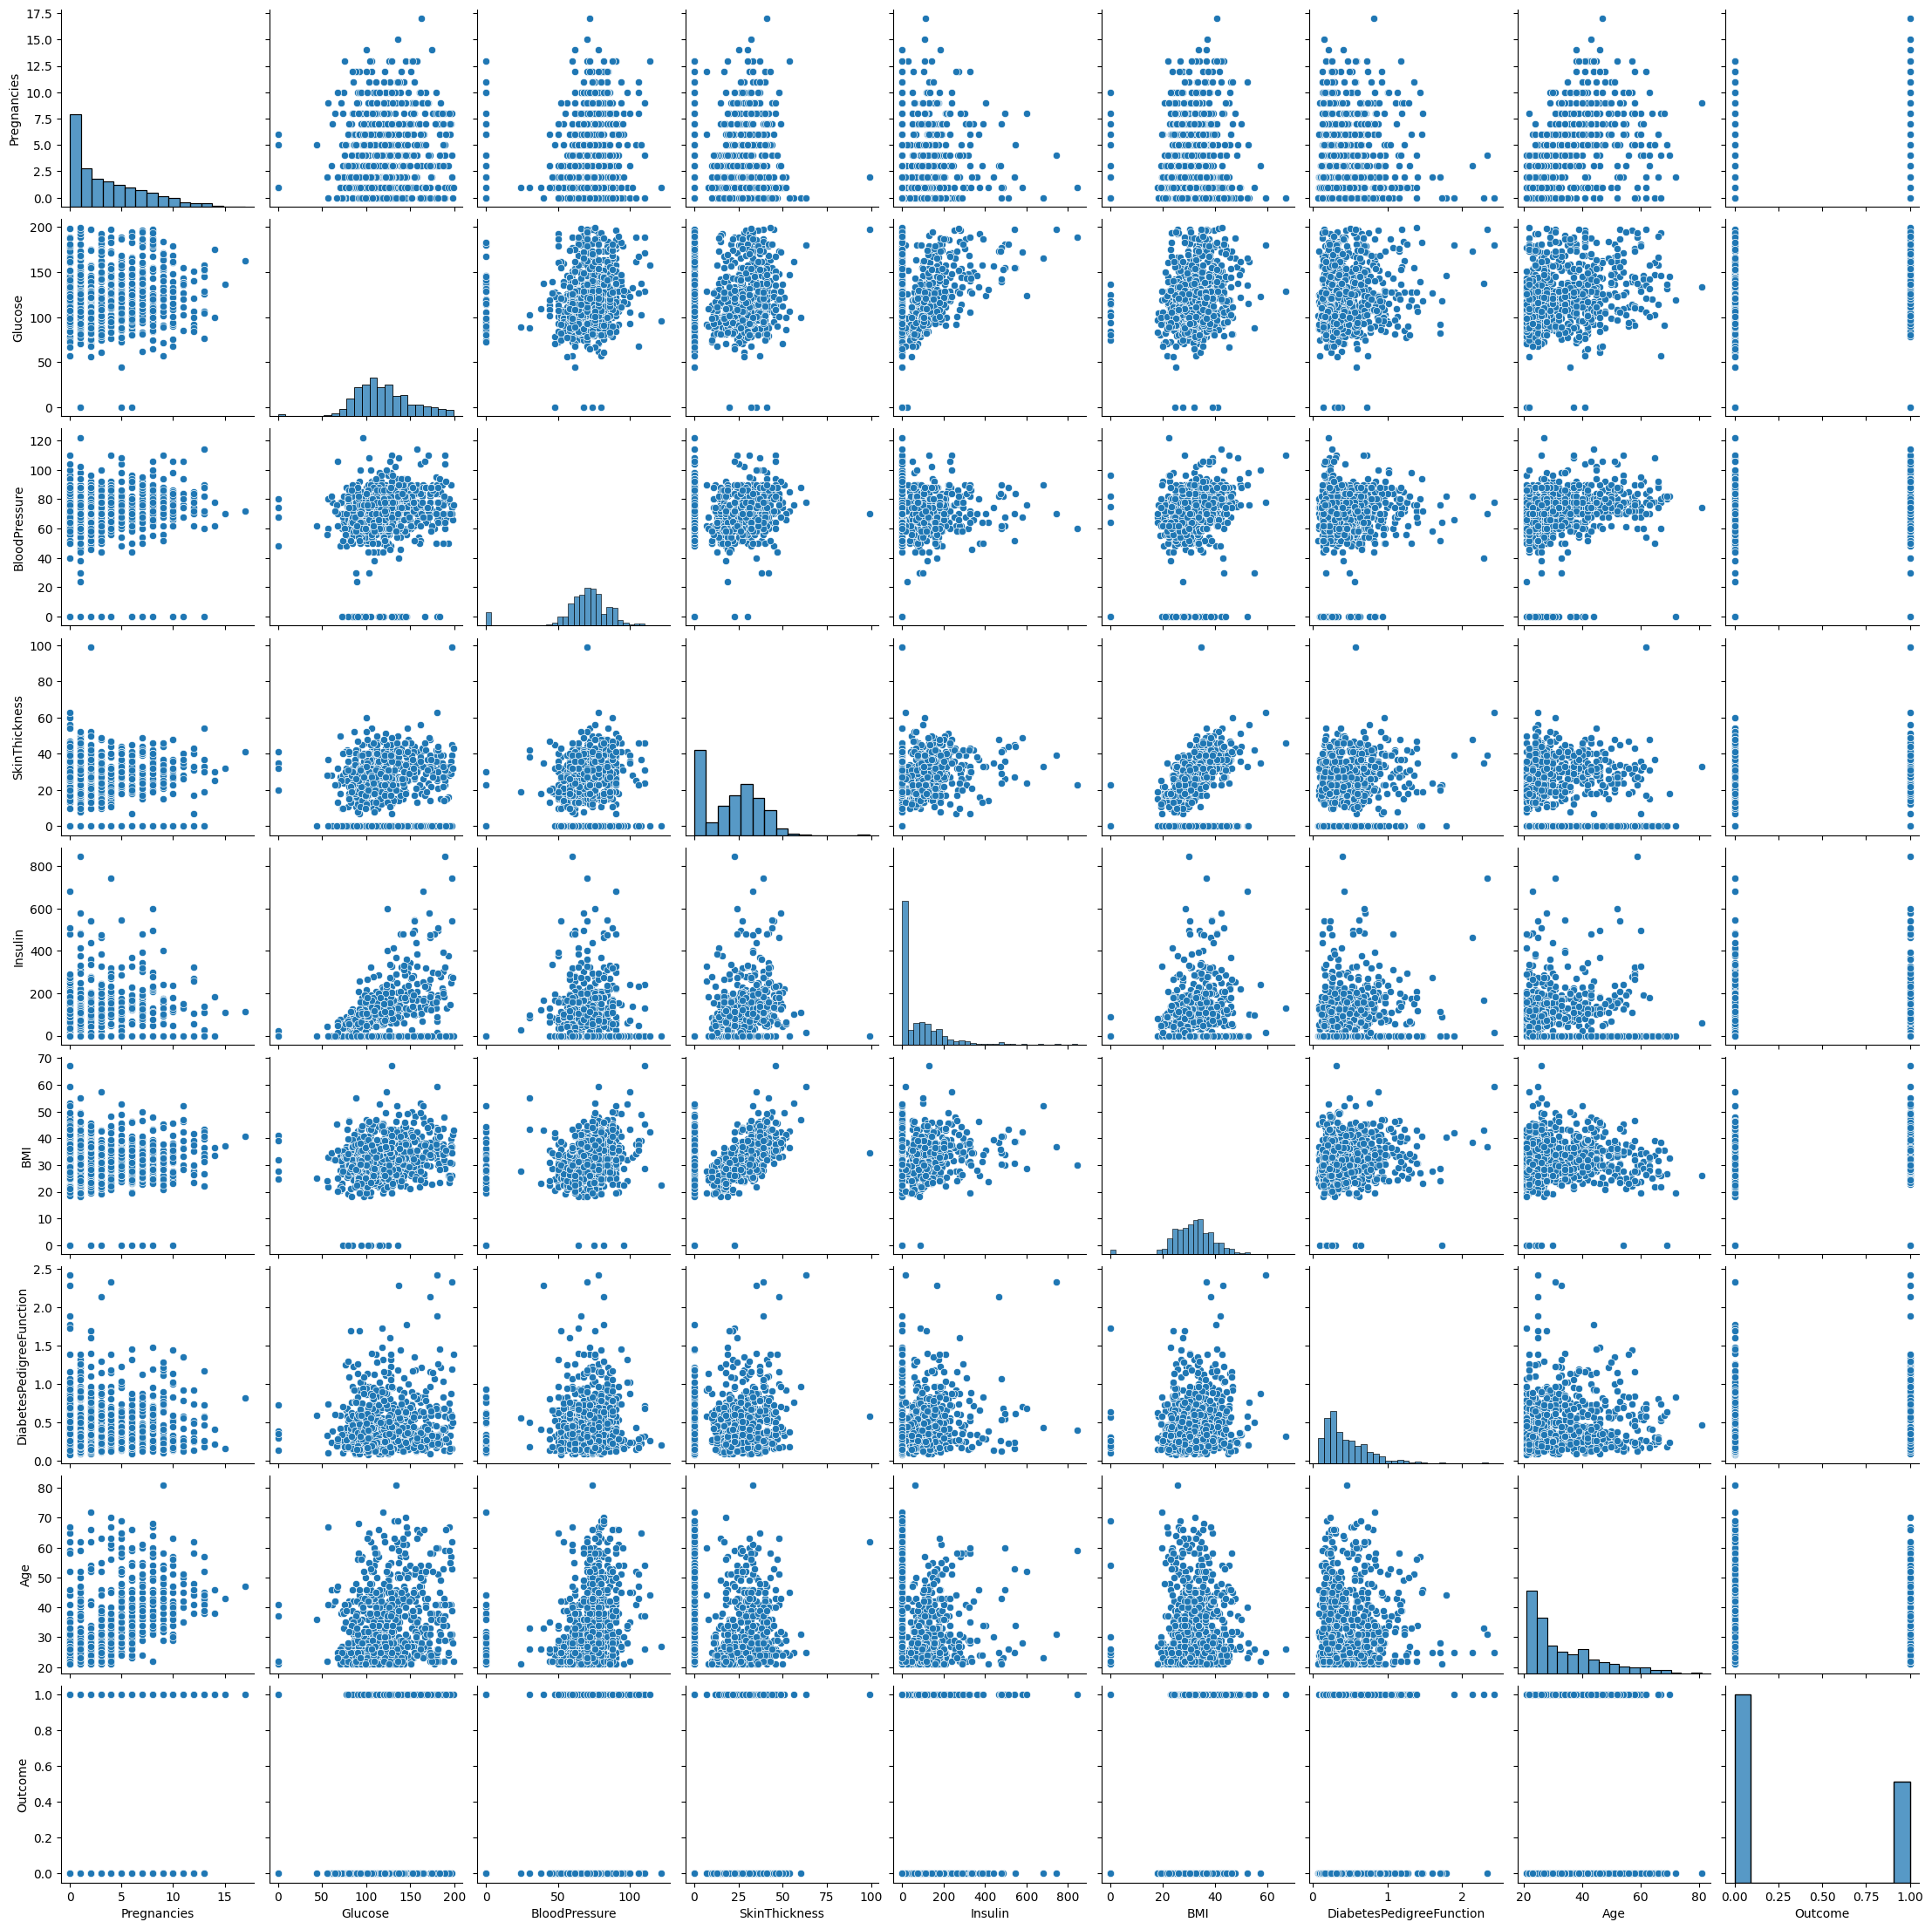

In [3]:
sns.pairplot(df)

### Манипуляции над столбцами для нормализации данных

In [4]:
new_df=df.copy()
new_df['Age']=np.log(np.log(df['Age'])+2)
new_df['DiabetesPedigreeFunction']=np.log(df['DiabetesPedigreeFunction'])
new_df['Insulin']=np.log(df['Insulin']+20)
new_df['SkinThickness']=np.log(df['SkinThickness']+20)
new_df['Pregnancies']=np.log(df['Pregnancies']+1)



## Построение решающего древа

### Сравнение логистической регрессии и решающего дерева

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score, make_scorer
from sklearn.model_selection import train_test_split,cross_val_score

models=[LogisticRegression(),DecisionTreeClassifier(random_state=42)]
scorers=[accuracy_score,precision_score,recall_score,f1_score]

X=new_df.copy()
y=X.pop('Outcome')


for model in models:
    print(f"Для модели {model}:")
    for scorer in scorers:
        score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(scorer)))
        print(f'{scorer.__name__} = {score}')

    print('---------------------------')





Для модели LogisticRegression():
accuracy_score = 0.772192513368984
precision_score = 0.7227556696619597
recall_score = 0.5672955974842767
f1_score = 0.6341313356202418
---------------------------
Для модели DecisionTreeClassifier(random_state=42):
accuracy_score = 0.7162974280621339
precision_score = 0.6056265189769027
recall_score = 0.5822501747030049
f1_score = 0.591311353565613
---------------------------


Для выбранного датасета логистическая регрессия проявляет себя лучше в классификации здоровых людей, но хуже в классификации больных

### Подбор оптимальной глубины дерева

Будем использовать recall, так как нам лучше ошибочно определить здорового как больного чем больного как здорового

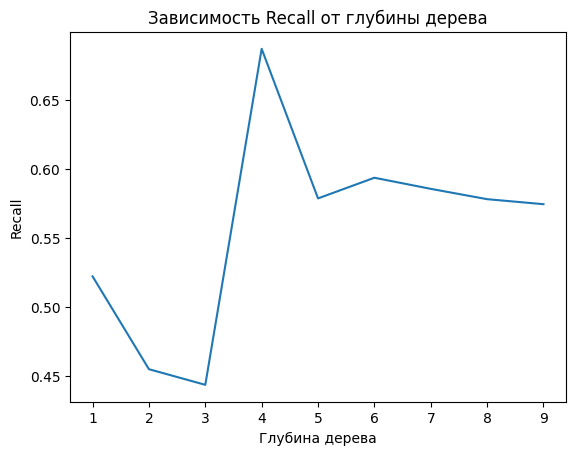

In [25]:
res=np.zeros(9)
for depth in range(1,10):
    model=DecisionTreeClassifier(max_depth=depth)
    score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(recall_score)))
    res[depth-1]=score

plt.xlabel('Глубина дерева')
plt.ylabel('Recall')
plt.title('Зависимость Recall от глубины дерева')

plt.plot(range(1,10),res)
plt.show()

Оптимальная глубина дерева - 4

### Показатели дерева с оптимальной глубиной

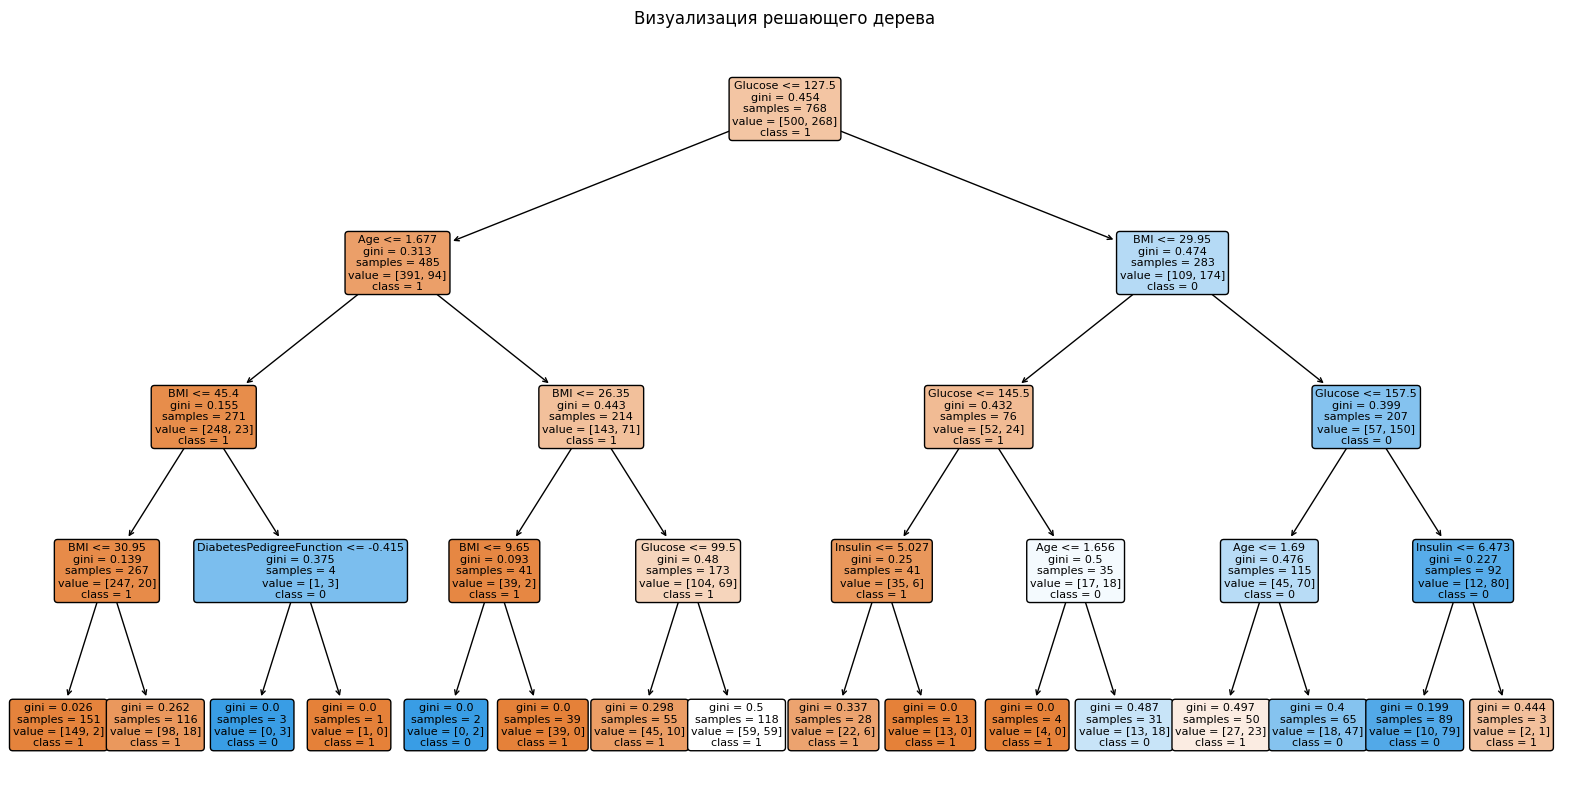

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(max_depth=4)
model.fit(X, y)

plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique().astype(str),
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title('Визуализация решающего дерева')
plt.show()


#### Важности признаков

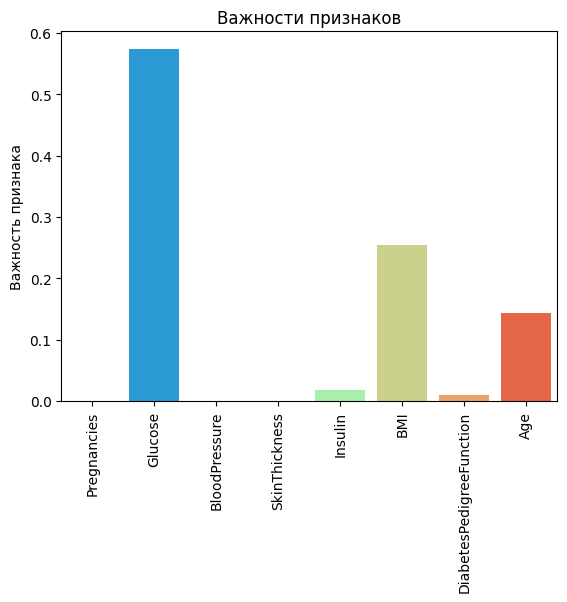

In [9]:
sns.barplot(y=model.feature_importances_,x=X.columns,palette='rainbow')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Важность признака')
plt.title('Важности признаков')
plt.show()

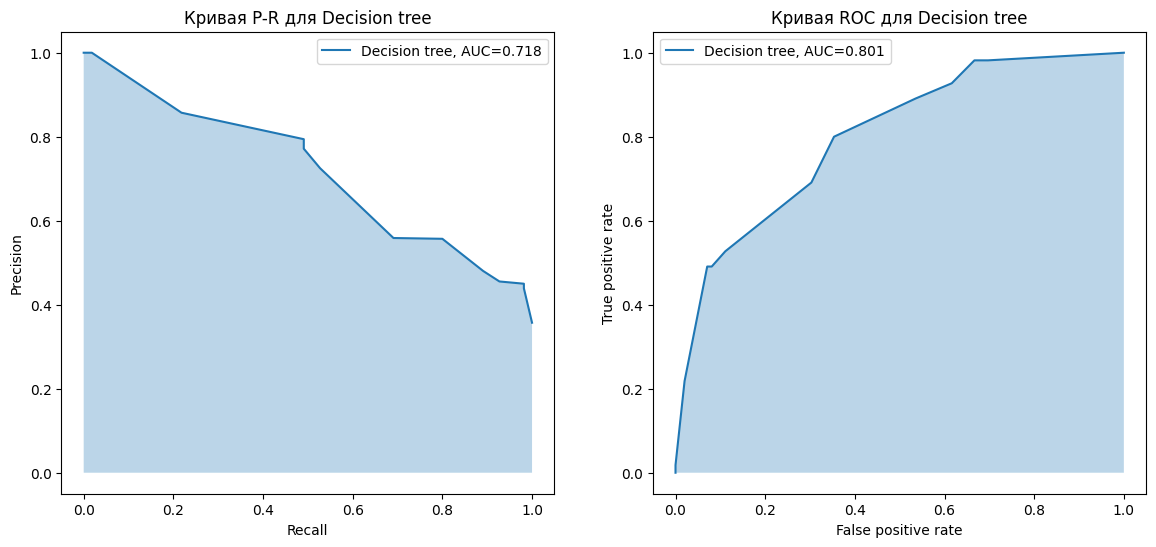

In [26]:
from sklearn.metrics import precision_recall_curve,auc,roc_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

fig,axs=plt.subplots(1,2,figsize=(14,6))

probabilities=model.predict_proba(X_test)[:,1]

precision, recall, _ =precision_recall_curve(y_test,probabilities)
fpr,tpr,_=roc_curve(y_test,probabilities)

axs[0].plot(recall,precision,label=f'Decision tree, AUC={auc(recall,precision):.3f}')
axs[0].fill_between(recall,precision,alpha=0.3)
axs[1].plot(fpr,tpr,label=f'Decision tree, AUC={auc(fpr,tpr):.3f}')
axs[1].fill_between(fpr,tpr,alpha=0.3)

axs[0].set_title('Кривая P-R для Decision tree')
axs[1].set_title('Кривая ROC для Decision tree')

axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')

axs[0].legend()
axs[1].legend()
plt.show()

Как видим, по сравнению с логистической регрессией (лабораторная 3) у кривых намного меньше ступеней

### Подбор других гиперпараметров

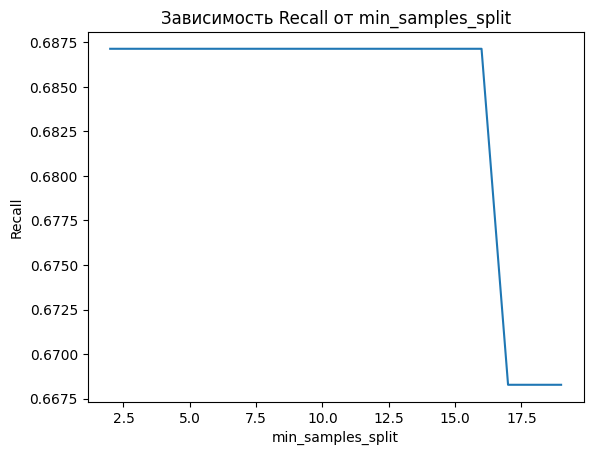

In [27]:
res=[]
for i in range(2,20):
    model=DecisionTreeClassifier(max_depth=4,min_samples_split=i,random_state=42)
    score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(recall_score)))
    res.append(score)

plt.xlabel('min_samples_split')
plt.ylabel('Recall')
plt.title('Зависимость Recall от min_samples_split')

plt.plot(range(2,20),res)
plt.show()

Возьмем min_samples_split равный 10

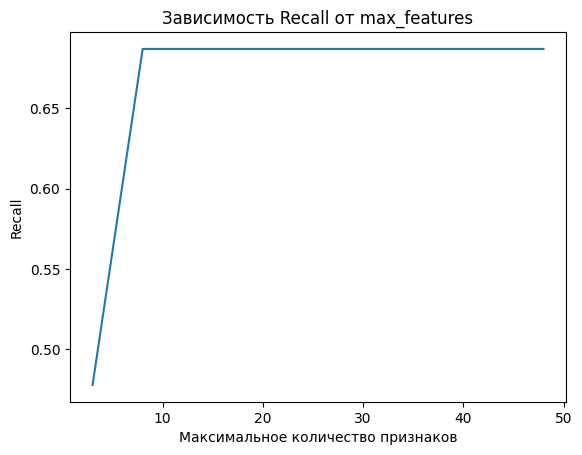

In [28]:
res=[]

for i in range(3,50,5):
    model=DecisionTreeClassifier(max_depth=4,min_samples_split=10,max_features=i,random_state=42)
    score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(recall_score)))
    res.append(score)

plt.xlabel('Максимальное количество признаков')
plt.ylabel('Recall')
plt.title('Зависимость Recall от max_features')

plt.plot(range(3,50,5),res)
plt.show()

Возьмем max_features равный 25

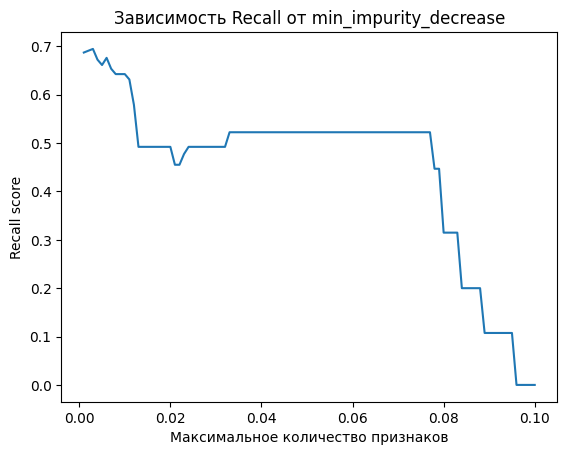

In [29]:
res=[]
feature_range=np.linspace(0.001,0.1,100)
for i in feature_range:
    model=DecisionTreeClassifier(max_depth=4,min_samples_split=10,max_features=25,min_impurity_decrease=i,random_state=42)
    score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(recall_score)))
    res.append(score)

plt.xlabel('Максимальное количество признаков')
plt.ylabel('Recall score')
plt.title('Зависимость Recall от min_impurity_decrease')

plt.plot(feature_range,res)
plt.show()

Приблизим значения близкие к 0

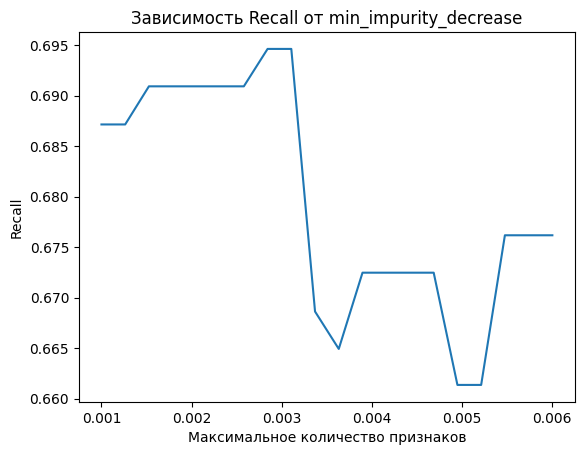

In [31]:
res=[]
feature_range=np.linspace(0.001,0.006,20)
for i in feature_range:
    model=DecisionTreeClassifier(max_depth=4,min_samples_split=10,max_features=25,min_impurity_decrease=i,random_state=42)
    score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(recall_score)))
    res.append(score)

plt.xlabel('Максимальное количество признаков')
plt.ylabel('Recall')
plt.title('Зависимость Recall от min_impurity_decrease')

plt.plot(feature_range,res)
plt.show()

Возьмем min_impurity_decrease равным 0.003

Сравнение логистической регрессии и решающего древа с подобранными параметрами

In [6]:
models=[DecisionTreeClassifier(),DecisionTreeClassifier(max_depth=4, max_features=25, min_samples_split=10,random_state=42,min_impurity_decrease=0.003)]
scorers=[accuracy_score,precision_score,recall_score,f1_score]

X=new_df.copy()
y=X.pop('Outcome')


for model in models:
    print(f"Для модели {model}:")
    for scorer in scorers:
        score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(scorer)))
        print(f'{scorer.__name__} = {score}')

    print('---------------------------')

Для модели DecisionTreeClassifier():
accuracy_score = 0.7148968678380443
precision_score = 0.6012939187974251
recall_score = 0.5709294199860238
f1_score = 0.5751591705784195
---------------------------
Для модели DecisionTreeClassifier(max_depth=4, max_features=25,
                       min_impurity_decrease=0.003, min_samples_split=10,
                       random_state=42):
accuracy_score = 0.7344198285374756
precision_score = 0.6067942373693033
recall_score = 0.6946191474493361
f1_score = 0.6454031529967359
---------------------------


Вывод: мы смогли увеличить recall на более чем 0.12